## Phase 3 (Data Preparation)

Datan esikäsittelyvaiheessa on tarkoitus käsitellä ja valmistella data sellaiseen kuntoon, että sitä voidaan käyttää helposti mallinnusvaiheessa ilman merkittäviä lisämuokkauksia.   
   
Vaiheessa keskitytyään esimerkiksi tietojen: 
- Puhdistamiseen 
- Muokkaamiseen 
- Valitsemiseen   

- Lopuksi data skaalataan ja/tai normalisoidaan. 

Vaiheessa on paljon tekemistä, mutta sen onnistuminen on tärkeä myös koko projektin onnistumisen kannalta. Datan esikäsittelyvaiheeseen saatetaan joutua palaamaan takaisin vielä myöhemmässä vaiheessa projektia. 


### Tästä lähtee datan esikäsittelyvaiheen toteutus

- Ladataan esikäsittelemätön data

In [1]:
#import kaggle
#import zipfile
import pandas as pd
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

file_path = r"C:\Lataukset\used_cars\used_cars_data.csv"

# Get the total number of rows
total_rows = sum(1 for _ in open(file_path, encoding='ISO-8859-1'))  # Count rows for progress

# Create an empty dataframe to accumulate chunks
dataframe = pd.DataFrame()


# Read in chunks and display a progress bar
#Poista nrows=1000000 jos haluat ladata kaikki rivit
chunk_size = 10000
for chunk in tqdm(pd.read_csv(file_path, nrows=1000000, chunksize=chunk_size), total=total_rows // chunk_size, desc="Loading CSV"):
    dataframe = pd.concat([dataframe, chunk])


print("Data loaded successfully.")

Loading CSV:  33%|███▎      | 100/300 [00:41<01:23,  2.40it/s]

Data loaded successfully.


In [2]:
#import pandas as pd
#from tqdm import tqdm
#import warnings
#warnings.filterwarnings('ignore')


#file_path = r"C:\Users\Omistaja\Desktop\AI_DA-projekti\aida-projekti-syksy-2024-ryhma-1\docs\us_used_cars\used_cars_data.csv"
#dataframe = pd.read_csv(file_path, nrows=100000)


Sarakkeiden poistoja:

- Poistetaan sarakkeita, joilla ei katsota olevan arvoa lopputuloksen kannalta
- Poistetaan sarakkeet, joissa liikaa NaN-arvoja
- Poistetaan toinen sellaisista sarakkeista, jotka sisältävät saman tiedon

In [3]:

# Näillä sarakkeilla ei katsota olevan arvoa lopputuloksen kannalta
dataframe.drop(columns=[
    'vin',
    'description',
    'listing_id',
    'main_picture_url',
    'bed',
    'bed_height',
    'bed_length',
    'cabin',
    'combine_fuel_economy',
    'is_certified',
    'is_cpo',
    'is_oemcpo',
    'latitude',
    'longitude',
    'vehicle_damage_category',
    'engine_type',
    'engine_cylinders'
    ],axis=1,inplace=True)

#`trim_name` ja `trimId` sisältävät samaa tietoa, joten pudotetaan `trimId`-sarake.
# `wheel_system` ja `wheel_system_display` sisältävät saman tiedon, joten poistetaan `wheel_system`.
dataframe.drop(columns=[
    'trimId', 
    'wheel_system'
    ],axis=1, inplace=True)

dataframe.info()
dataframe.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 47 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   back_legroom          951854 non-null   object 
 1   body_type             995631 non-null   object 
 2   city                  1000000 non-null  object 
 3   city_fuel_economy     836741 non-null   float64
 4   daysonmarket          1000000 non-null  int64  
 5   dealer_zip            1000000 non-null  object 
 6   engine_displacement   948298 non-null   float64
 7   exterior_color        984313 non-null   object 
 8   fleet                 536735 non-null   object 
 9   frame_damaged         536735 non-null   object 
 10  franchise_dealer      1000000 non-null  bool   
 11  franchise_make        803215 non-null   object 
 12  front_legroom         951854 non-null   object 
 13  fuel_tank_volume      951854 non-null   object 
 14  fuel_type             975236 non-nu

,back_legroom,body_type,city,city_fuel_economy,daysonmarket,dealer_zip,engine_displacement,exterior_color,fleet,frame_damaged,...,sp_name,theft_title,torque,transmission,transmission_display,trim_name,wheel_system_display,wheelbase,width,year
0,35.1 in,SUV / Crossover,Bayamon,NaN,522,960,1300.0,Solar Yellow,NaN,NaN,...,Flagship Chrysler,NaN,"200 lb-ft @ 1,750 RPM",A,9-Speed Automatic Overdrive,Latitude FWD,Front-Wheel Drive,101.2 in,79.6 in,2019
1,38.1 in,SUV / Crossover,San Juan,NaN,207,922,2000.0,Narvik Black,NaN,NaN,...,Land Rover San Juan,NaN,"269 lb-ft @ 1,400 RPM",A,9-Speed Automatic Overdrive,S AWD,All-Wheel Drive,107.9 in,85.6 in,2020
2,35.4 in,Sedan,Guaynabo,17.0,1233,969,2500.0,NaN,False,False,...,FIAT de San Juan,False,"290 lb-ft @ 4,000 RPM",M,6-Speed Manual,Base,All-Wheel Drive,104.3 in,78.9 in,2016
3,37.6 in,SUV / Crossover,San Juan,NaN,196,922,3000.0,Eiger Gray,NaN,NaN,...,Land Rover San Juan,NaN,"332 lb-ft @ 3,500 RPM",A,8-Speed Automatic Overdrive,V6 HSE AWD,All-Wheel Drive,115 in,87.4 in,2020
4,38.1 in,SUV / Crossover,San Juan,NaN,137,922,2000.0,Narvik Black,NaN,NaN,...,Land Rover San Juan,NaN,"269 lb-ft @ 1,400 RPM",A,9-Speed Automatic Overdrive,S AWD,All-Wheel Drive,107.9 in,85.6 in,2020


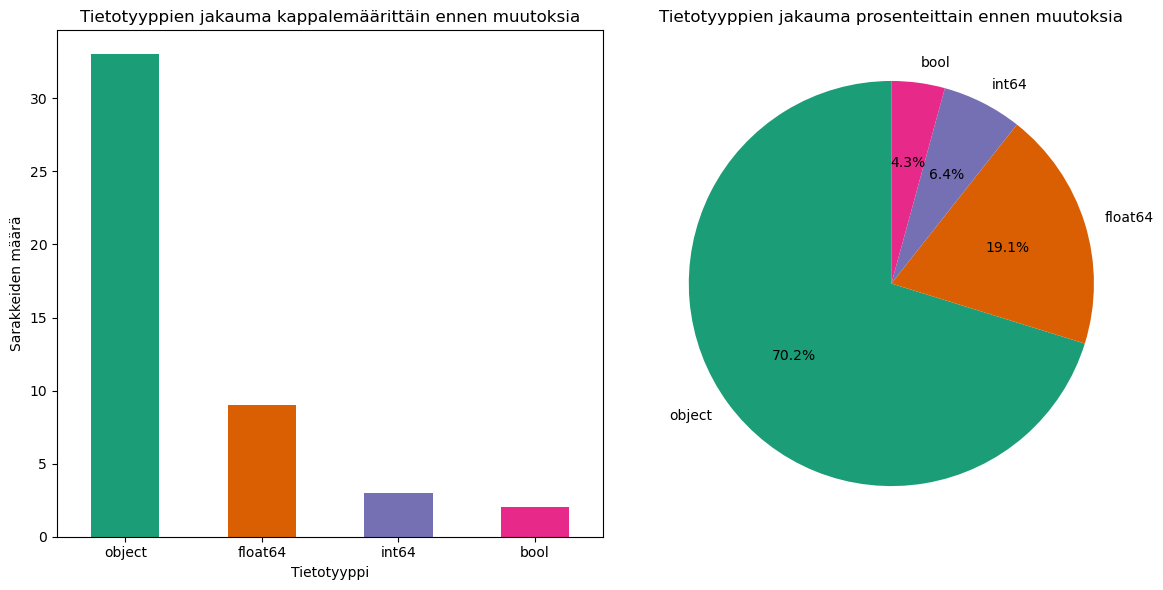

In [4]:
import matplotlib.pyplot as plt
from matplotlib import cm

data_types_plot1 = dataframe.dtypes.value_counts()
colors = cm.Dark2.colors

fig, axes = plt.subplots(1, 2, figsize=(12,6))

# Barplot
data_types_plot1.plot(
    kind="bar",
    ax=axes[0],
    title="Tietotyyppien jakauma kappalemäärittäin ennen muutoksia",
    xlabel="Tietotyyppi",
    ylabel="Sarakkeiden määrä",
    color=colors
)

axes[0].tick_params(axis="x", rotation=0)

# Pie
data_types_plot1.plot(
    kind="pie",
    ax=axes[1],
    autopct="%1.1f%%",
    startangle=90,
    title="Tietotyyppien jakauma prosenteittain ennen muutoksia",
    ylabel="",
    colors=colors
)


# Show the plot
plt.tight_layout()
plt.show()

Data-tyyppien muutokset:

- Muutetaan objekti-tyyppiset sarakkeet numeeriseksi ja booleaniksi kun mahdollista
- Päivämäärän käsittely

In [5]:
# Preprosessataan nämä objekti-kolumnit numeriseksi:

# back_legroom numeriseksi
dataframe['back_legroom'] = dataframe['back_legroom'].astype(str).apply(lambda x: x.split()[0])
dataframe['back_legroom'] = pd.to_numeric(dataframe['back_legroom'], errors='coerce')

# dealer_zip numeriseksi
dataframe['dealer_zip'] = pd.to_numeric(dataframe['dealer_zip'], errors='coerce')
#print(dataframe['dealer_zip'].dtype) - float64

# front_legroom numeriseksi
dataframe['front_legroom'] = dataframe['front_legroom'].astype(str).apply(lambda x: x.split()[0])
dataframe['front_legroom'] = pd.to_numeric(dataframe['front_legroom'], errors='coerce')

# fuel_tank_volume numeriseksi
dataframe['fuel_tank_volume'] = dataframe['fuel_tank_volume'].astype(str).apply(lambda x: x.split()[0])
dataframe['fuel_tank_volume'] = pd.to_numeric(dataframe['fuel_tank_volume'], errors='coerce')

# height numeriseksi
dataframe['height'] = dataframe['height'].astype(str).apply(lambda x: x.split()[0])
dataframe['height'] = pd.to_numeric(dataframe['height'], errors='coerce')

# lenght numeriseksi
dataframe['length'] = dataframe['length'].astype(str).apply(lambda x: x.split()[0])
dataframe['length'] = pd.to_numeric(dataframe['length'], errors='coerce')

# maximum_seating numeriseksi
dataframe['maximum_seating'] = dataframe['maximum_seating'].astype(str).apply(lambda x: x.split()[0])
dataframe['maximum_seating'] = pd.to_numeric(dataframe['maximum_seating'], errors='coerce')

# wheelbase numeriseksi
dataframe['wheelbase'] = dataframe['wheelbase'].astype(str).apply(lambda x: x.split()[0])
dataframe['wheelbase'] = pd.to_numeric(dataframe['wheelbase'], errors='coerce')

# width numeriseksi
dataframe['width'] = dataframe['width'].astype(str).apply(lambda x: x.split()[0])
dataframe['width'] = pd.to_numeric(dataframe['width'], errors='coerce')




In [6]:
df_copy = dataframe.copy()

# Fill NaN values with 'False' 
df_copy['fleet'] = df_copy['fleet'].fillna('False') 

# Convert the column to boolean type 
df_copy['fleet'] = df_copy['fleet'].astype(bool) 

# Count the number of True and False values in the 'fleet' column
true_count_fleet = df_copy['fleet'].value_counts().get(True, 0)
false_count_fleet = df_copy['fleet'].value_counts().get(False, 0)
null_count = df_copy['fleet'].isna().sum()
# Create a new DataFrame with the counts
fleet_counts = pd.DataFrame({
    'True': [true_count_fleet],
    'False': [false_count_fleet],
    'Null': [null_count]
})

print(fleet_counts)
print(df_copy['fleet'].dtypes)
# Show the sums of unique values in the 'fleet_3' column
unique_value_counts = df_copy['fleet'].value_counts()

# Display the result
print(unique_value_counts)

     True   False  Null
0  544621  455379     0
bool
fleet
True     544621
False    455379
Name: count, dtype: int64


In [7]:
# Preprosessataan nämä objekti-kolumnit booleaniksi:

# fleet boolenaiksi
dataframe['fleet'] = dataframe['fleet'].fillna('False')
dataframe['fleet'] = dataframe['fleet'].astype(bool)

# frame_damaged boolenaiksi
dataframe['frame_damaged'] = dataframe['frame_damaged'].fillna('False')
dataframe['frame_damaged'] = dataframe['frame_damaged'].astype(bool)

# has_accidents boolenaiksi
dataframe['has_accidents'] = dataframe['has_accidents'].fillna('False')
dataframe['has_accidents'] = dataframe['has_accidents'].astype(bool)

# isCab booleaniksi
dataframe['isCab'] = dataframe['isCab'].fillna('False')
dataframe['isCab'] = dataframe['isCab'].astype(bool)

# salvage booleaniksi
dataframe['salvage'] = dataframe['salvage'].fillna('False') 
dataframe['salvage'] = dataframe['salvage'].astype(bool)

# theft_title booleaniksi
dataframe['theft_title'] = dataframe['theft_title'].fillna('False')
dataframe['theft_title'] = dataframe['theft_title'].astype(bool)


In [8]:
#Tarkistetatan menikö oikein
true_count_fleet = dataframe['fleet'].value_counts().get(True, 0)
false_count_fleet = dataframe['fleet'].value_counts().get(False, 0)

fleet_counts = pd.DataFrame({
    'True': [true_count_fleet],
    'False': [false_count_fleet]
})

print(fleet_counts)
# Verify the change by checking unique values in the column
print(dataframe['fleet'].unique())
dataframe['fleet']


     True   False
0  544621  455379
[ True False]


0          True
1          True
2         False
3          True
4          True
          ...  
999995     True
999996    False
999997     True
999998     True
999999    False
Name: fleet, Length: 1000000, dtype: bool

In [9]:
# Päivämäärän käsittely ja luodaan uusia sarakkeita

# muutetaan date datetimeen
dataframe['listed_date'] = pd.to_datetime(dataframe['listed_date'], errors='coerce')

# lisätietoa vuosista päivistä ja kuukausista
dataframe['listed_year'] = dataframe['listed_date'].dt.year
dataframe['listed_month'] = dataframe['listed_date'].dt.month
dataframe['listed_dayofweek'] = dataframe['listed_date'].dt.dayofweek

In [10]:
# Jaetaan power -sarake hevosvoimiksi (power_hp) ja kierrosluvuiksi (power_rmp)

dataframe['power_hp'] = dataframe['power'].apply(lambda x: x.split()[0] if isinstance(x, str) else None)
dataframe['power_rpm'] = dataframe['power'].apply(lambda x: x.split()[3] if isinstance(x, str) and len(x.split()) >= 4 else None)

dataframe['power_hp'] = pd.to_numeric(dataframe['power_hp'], errors='coerce')
dataframe['power_rpm'] = pd.to_numeric(dataframe['power_rpm'], errors='coerce')

# Poistetaan alkuperäinen power -sarake
dataframe.drop(columns=['power'], inplace=True)


In [11]:
# Jaetaan torque samalla tavallu kun power
dataframe['torque_value'] = dataframe['torque'].apply(lambda x: x.split()[0] if isinstance(x, str) else None)
dataframe['torque_rpm'] = dataframe['torque'].apply(lambda x: x.split()[3] if isinstance(x, str) and len(x.split()) >= 4 else None)

dataframe['torque_value'] = pd.to_numeric(dataframe['torque_value'], errors='coerce')
dataframe['torque_rpm'] = pd.to_numeric(dataframe['torque_rpm'], errors='coerce')

# Poistetaan alkuperäinen torque -sarake
dataframe.drop(columns=['torque'], inplace=True)



In [12]:

# sp_name on hankala, koska niin monta unique arvoa voi joko dropata tai ehkä ryhmitellä top 10 myyjää
# dataframe.drop(columns=['sp_name'], inplace=True)



Välitsekkaus sarakkeiden tyyppimuunnoksista.

In [13]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 52 columns):
 #   Column                Non-Null Count    Dtype         
---  ------                --------------    -----         
 0   back_legroom          920904 non-null   float64       
 1   body_type             995631 non-null   object        
 2   city                  1000000 non-null  object        
 3   city_fuel_economy     836741 non-null   float64       
 4   daysonmarket          1000000 non-null  int64         
 5   dealer_zip            999791 non-null   float64       
 6   engine_displacement   948298 non-null   float64       
 7   exterior_color        984313 non-null   object        
 8   fleet                 1000000 non-null  bool          
 9   frame_damaged         1000000 non-null  bool          
 10  franchise_dealer      1000000 non-null  bool          
 11  franchise_make        803215 non-null   object        
 12  front_legroom         946602 non-null   flo

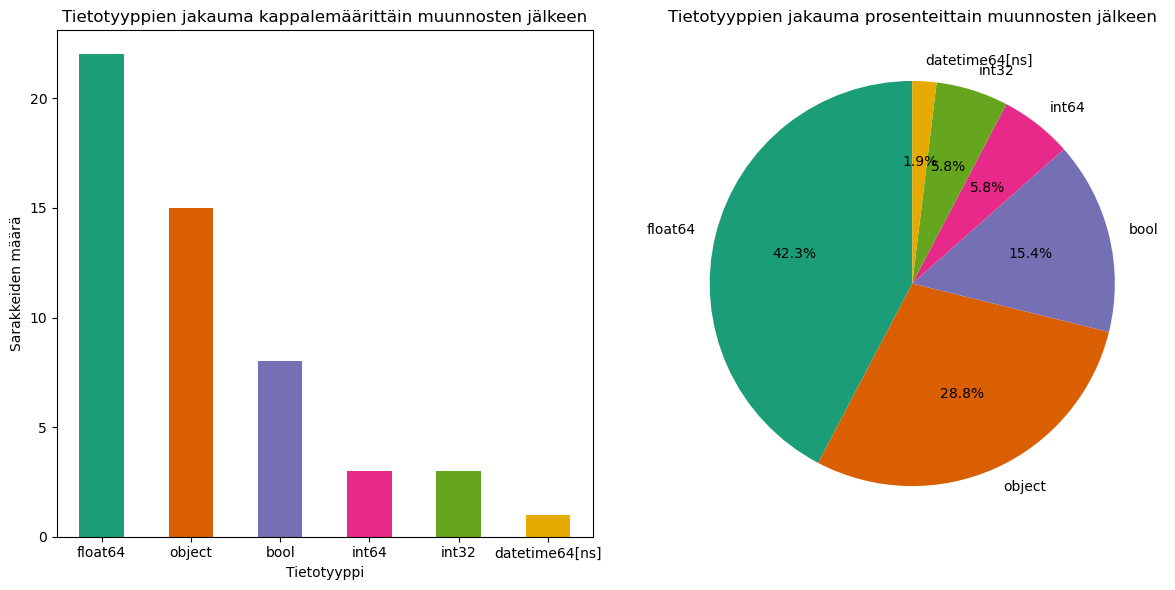

In [14]:
import matplotlib.pyplot as plt

data_types_plot2 = dataframe.dtypes.value_counts()
colors = cm.Dark2.colors

fig, axes = plt.subplots(1, 2, figsize=(12,6))

# Barplot
data_types_plot2.plot(
    kind="bar",
    ax=axes[0],
    title="Tietotyyppien jakauma kappalemäärittäin muunnosten jälkeen",
    xlabel="Tietotyyppi",
    ylabel="Sarakkeiden määrä",
    color=colors
)

axes[0].tick_params(axis="x", rotation=0)

# Pie
data_types_plot2.plot(
    kind="pie",
    ax=axes[1],
    autopct="%1.1f%%",
    startangle=90,
    title="Tietotyyppien jakauma prosenteittain muunnosten jälkeen",
    ylabel="",
    colors=colors
)

# Show the plot
plt.tight_layout()
plt.show()

In [15]:
print("Statistical Summary of Numerical Columns:")
dataframe = dataframe.query('year >= 1990')
round(dataframe.select_dtypes(exclude = ['object']).describe() , 2)

Statistical Summary of Numerical Columns:


,back_legroom,city_fuel_economy,daysonmarket,dealer_zip,engine_displacement,front_legroom,fuel_tank_volume,height,highway_fuel_economy,horsepower,...,wheelbase,width,year,listed_year,listed_month,listed_dayofweek,power_hp,power_rpm,torque_value,torque_rpm
count,920749.00,836514.00,998306.00,998097.00,947890.00,946314.00,951281.00,951335.00,836514.00,947890.00,...,951338.00,951339.00,998306.00,998306.00,998306.00,998306.00,848534.00,1307.00,836384.00,21390.00
mean,37.87,22.40,77.69,26077.54,2885.08,42.14,18.37,65.81,29.14,243.23,...,114.26,78.22,2017.66,2019.92,7.27,3.49,246.90,633.45,258.28,200.86
min,0.00,7.00,0.00,922.00,700.00,0.00,1.90,43.70,10.00,70.00,...,73.50,42.50,1990.00,2010.00,1.00,0.00,70.00,516.00,68.00,200.00
25%,36.00,18.00,14.00,11207.00,2000.00,41.00,14.50,58.30,25.00,174.00,...,106.20,72.40,2017.00,2020.00,7.00,2.00,174.00,600.00,175.00,200.00
50%,38.10,21.00,35.00,21157.00,2500.00,41.80,17.30,66.10,28.00,240.00,...,110.50,77.20,2019.00,2020.00,8.00,4.00,245.00,650.00,258.00,200.00
75%,39.60,26.00,83.00,44124.00,3500.00,43.00,21.00,69.90,33.00,295.00,...,117.30,82.80,2020.00,2020.00,8.00,5.00,301.00,650.00,295.00,200.00
max,59.80,127.00,3573.00,99518.00,8400.00,67.00,64.00,117.60,127.00,1001.00,...,201.00,109.00,2021.00,2020.00,12.00,6.00,903.00,650.00,935.00,400.00
std,3.03,7.84,109.49,18475.66,1280.00,1.50,5.15,7.33,7.07,87.29,...,13.62,7.46,3.69,0.30,2.14,1.68,88.02,28.36,112.19,8.94


Katsotaan mitä arvoja jäljelle jääneet "object" -tyyppiset sarakkeet pitävät sisällään.

Nämä pitää esikäsitellä mallin ymmärtämään muotoon, esim. encoding.

Osassa sarakkeita liikaa uniikkeja arvoja encoodauksen kannalta.

In [16]:
cat_cols = dataframe.select_dtypes(include=['object']).columns
for col in cat_cols:
    unique_values = dataframe[col].unique()
    print(f"Total unique values: {len(unique_values)}")
    print("Top 10 most common values:")
    print(dataframe[col].value_counts().head(10))  # Show top 10 most common values
    print("\n")


Total unique values: 10
Top 10 most common values:
body_type
SUV / Crossover    508581
Sedan              236548
Pickup Truck       134055
Hatchback           28797
Minivan             25577
Coupe               19791
Van                 19310
Wagon               14079
Convertible          7336
Name: count, dtype: int64


Total unique values: 3212
Top 10 most common values:
city
Columbus          10471
Raleigh            9241
Chicago            8832
Charlotte          8088
Richmond           7636
Rochester          5313
Virginia Beach     5255
Pittsburgh         5226
Grand Rapids       5021
Knoxville          4988
Name: count, dtype: int64


Total unique values: 15007
Top 10 most common values:
exterior_color
Black                     58651
White                     38419
Summit White              30202
Gray                      27178
Silver                    25104
Blue                      19718
Oxford White              17239
Red                       14337
Bright White Clearcoat    

In [17]:
cat_cols = dataframe.select_dtypes(include=['object']).columns

# Calculate null counts for each categorical column
null_counts = dataframe[cat_cols].isnull().sum()
print(null_counts)

body_type                 4232
city                         0
exterior_color           15649
franchise_make          195318
fuel_type                23617
interior_color          119650
listing_color                0
major_options            66700
make_name                    0
model_name                   0
sp_name                      0
transmission             16484
transmission_display     16484
trim_name                35403
wheel_system_display     44349
dtype: int64


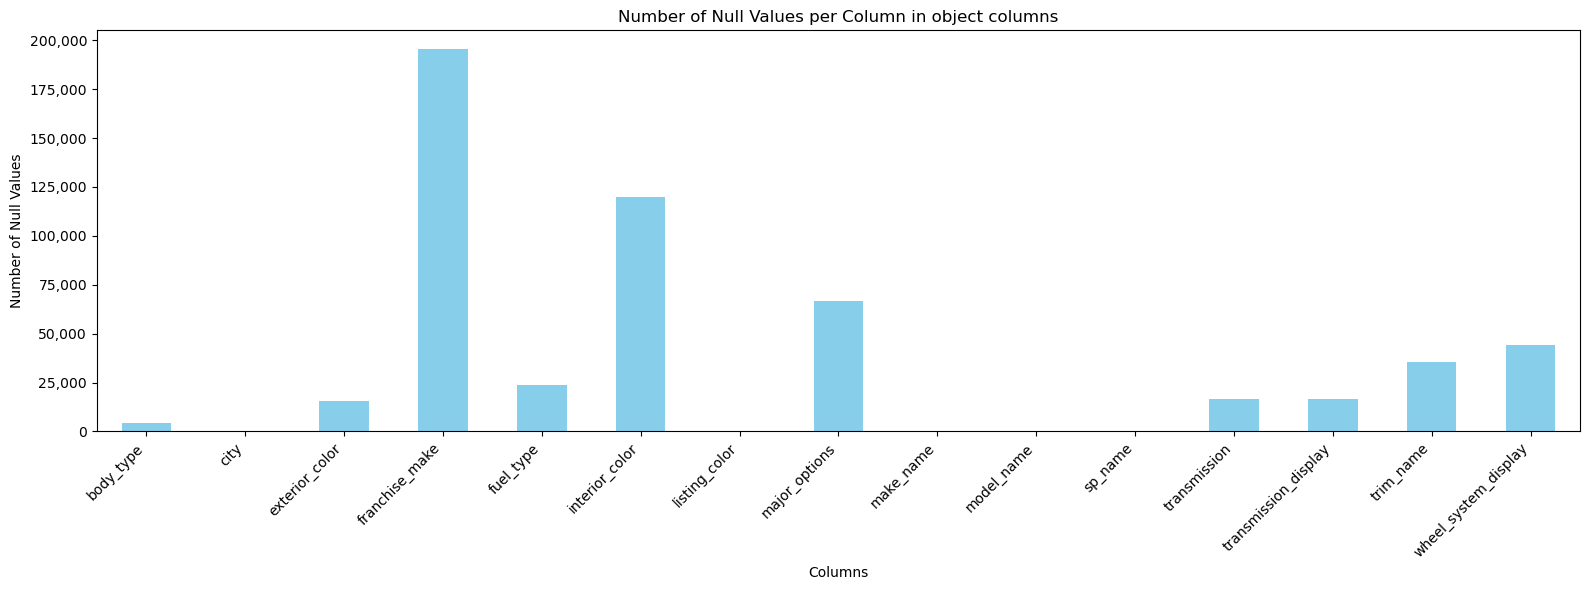

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 6))
null_counts.plot.bar(color='skyblue')
plt.title('Number of Null Values per Column in object columns')
plt.xlabel('Columns')
plt.ylabel('Number of Null Values')
plt.xticks(rotation=45, ha='right')

plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x):,}'))
plt.tight_layout()
plt.show()

In [19]:
columns_to_check = ['front_legroom', 'fuel_tank_volume', 'height', 'maximum_seating', 
                    'power_hp', 'power_rpm', 'torque_rpm', 'wheelbase', 'width', 'back_legroom']

for col in columns_to_check:
    count = (dataframe[col] == '--').sum()
    print(f"Column '{col}' has {count} rows with '--'")
    

Column 'front_legroom' has 0 rows with '--'
Column 'fuel_tank_volume' has 0 rows with '--'
Column 'height' has 0 rows with '--'
Column 'maximum_seating' has 0 rows with '--'
Column 'power_hp' has 0 rows with '--'
Column 'power_rpm' has 0 rows with '--'
Column 'torque_rpm' has 0 rows with '--'
Column 'wheelbase' has 0 rows with '--'
Column 'width' has 0 rows with '--'
Column 'back_legroom' has 0 rows with '--'


In [20]:
a =('''
Muutettu objekteista numeeriseksi dataa. Joitakin booliksi meneviä jäänyt objektiksi NaN arvojen takia. Dropattu turhia sarakkeita.
Työstetty date column -> muutama uusi. Jotkut objektit vaativat työstöä encodingina varten. 
''')
print(a)


Muutettu objekteista numeeriseksi dataa. Joitakin booliksi meneviä jäänyt objektiksi NaN arvojen takia. Dropattu turhia sarakkeita.
Työstetty date column -> muutama uusi. Jotkut objektit vaativat työstöä encodingina varten. 



In [21]:
sara = ('''
Jouduin rullaamaan koodin nrows=1000000 rivillä kun ei oikein mennyt läpi koko datalla, eli voi alusta tuon poistaa ken kykenee datan ajaa koko datalla :D
Siistitty koodia ehkä selkeämpiin kokonaisuuksiin (mitä tehty missäkin vaiheessa), pudotettu sarakkeita ja muokattu tyyppejä, Valtteri oli kyllä jo hyvin alustanutkin tyyppimuunnoksia
One-hot-encoodaus varmaan tuonne missä muitakin sarakkeiden tyyppimuunnoksia.. voi olla kyllä muuallakin jos katsoo parhaaksi
''')
print(sara)


Jouduin rullaamaan koodin nrows=1000000 rivillä kun ei oikein mennyt läpi koko datalla, eli voi alusta tuon poistaa ken kykenee datan ajaa koko datalla :D
Siistitty koodia ehkä selkeämpiin kokonaisuuksiin (mitä tehty missäkin vaiheessa), pudotettu sarakkeita ja muokattu tyyppejä, Valtteri oli kyllä jo hyvin alustanutkin tyyppimuunnoksia
One-hot-encoodaus varmaan tuonne missä muitakin sarakkeiden tyyppimuunnoksia.. voi olla kyllä muuallakin jos katsoo parhaaksi



NaN-arvojen käsittelyä ja lisää sarakkeiden poistoa:

- Katsotaan sarakkeittain NaN-arvojen määriä suuruus järjestyksessä
- Yhdistetään 'make_name' ja 'franchise_make' -sarakkeet, sillä suuri osa arvoista yhtenäisiä
- Poistetaan sarakkeet, jotka pitävät sisällään suurimman määrän NaN-arvoja
- Lopuksi poistetaan kaikki rivit, jotka pitävät sisällään NaN-arvoja

In [22]:
nan_counts = pd.DataFrame({'Column': dataframe.columns, 'NaN_Count': dataframe.isna().sum()}).reset_index(drop=True)
nan_counts_sorted = nan_counts.sort_values(by='NaN_Count', ascending=False).reset_index(drop=True)

print(f"Rivien määrä: {len(dataframe)}")
print(f"Sarakkeiden määrä: {len(dataframe.columns)}")
print("tyhjien arvojen määrä per sarake")
print(nan_counts_sorted)

Rivien määrä: 998306
Sarakkeiden määrä: 52
tyhjien arvojen määrä per sarake
                  Column  NaN_Count
0              power_rpm     996999
1             torque_rpm     976916
2            owner_count     493681
3         franchise_make     195318
4           torque_value     161922
5      city_fuel_economy     161792
6   highway_fuel_economy     161792
7               power_hp     149772
8         interior_color     119650
9           back_legroom      77557
10         major_options      66700
11         front_legroom      51992
12               mileage      50474
13   engine_displacement      50416
14            horsepower      50416
15      fuel_tank_volume      47025
16       maximum_seating      46991
17                height      46971
18             wheelbase      46968
19                length      46968
20                 width      46967
21  wheel_system_display      44349
22             trim_name      35403
23             fuel_type      23617
24  transmission_display

In [23]:
# Filter rows with non-NaN values in 'power_rpm'
filtered_df = dataframe[dataframe['power_rpm'].notna()]

len(filtered_df)

1307

In [24]:
# Replace NaN in franchise_make with values from make_name
dataframe['franchise_make'] = dataframe['franchise_make'].fillna(dataframe['make_name'])

# Find rows where franchise_make is different from make_name
mismatch_count = (dataframe['franchise_make'] != dataframe['make_name']).sum()

print(f"Number of rows with different franchise_make and make_name: {mismatch_count}")

Number of rows with different franchise_make and make_name: 142670


In [25]:
#tarkistetaan nyt franchise make

nan_counts = pd.DataFrame({'Column': dataframe.columns, 'NaN_Count': dataframe.isna().sum()}).reset_index(drop=True)
nan_counts_sorted = nan_counts.sort_values(by='NaN_Count', ascending=False).reset_index(drop=True)

print(f"Rivien määrä: {len(dataframe)}")
print(f"Sarakkeiden määrä: {len(dataframe.columns)}")
print("tyhjien arvojen määrä per sarake")
print(nan_counts_sorted)

Rivien määrä: 998306
Sarakkeiden määrä: 52
tyhjien arvojen määrä per sarake
                  Column  NaN_Count
0              power_rpm     996999
1             torque_rpm     976916
2            owner_count     493681
3           torque_value     161922
4   highway_fuel_economy     161792
5      city_fuel_economy     161792
6               power_hp     149772
7         interior_color     119650
8           back_legroom      77557
9          major_options      66700
10         front_legroom      51992
11               mileage      50474
12   engine_displacement      50416
13            horsepower      50416
14      fuel_tank_volume      47025
15       maximum_seating      46991
16                height      46971
17             wheelbase      46968
18                length      46968
19                 width      46967
20  wheel_system_display      44349
21             trim_name      35403
22             fuel_type      23617
23  transmission_display      16484
24          transmission

In [26]:
#poistetaan eniten tyhjiä arvoja sisältävät sarakkeet
dataframe.drop(columns=['power_rpm', 'torque_rpm', 'owner_count'], inplace=True)

nan_counts = pd.DataFrame({'Column': dataframe.columns, 'NaN_Count': dataframe.isna().sum()}).reset_index(drop=True)
nan_counts_sorted = nan_counts.sort_values(by='NaN_Count', ascending=False).reset_index(drop=True)

print(f"Rivien määrä: {len(dataframe)}")
print(f"Sarakkeiden määrä: {len(dataframe.columns)}")
print("tyhjien arvojen määrä per sarake")
print(nan_counts_sorted.head(10))

Rivien määrä: 998306
Sarakkeiden määrä: 49
tyhjien arvojen määrä per sarake
                 Column  NaN_Count
0          torque_value     161922
1  highway_fuel_economy     161792
2     city_fuel_economy     161792
3              power_hp     149772
4        interior_color     119650
5          back_legroom      77557
6         major_options      66700
7         front_legroom      51992
8               mileage      50474
9   engine_displacement      50416


In [27]:
#Testataan paljonko jää rivejä jos poistetaan kaikki NaN

cleaned_df = dataframe.dropna()

print(cleaned_df.shape)

(572253, 49)


In [28]:
#Testataan jos poistetaan seuraavat 3 suurinta NaN arvollista saraketta, sekä power_hp joka on jo horsepower -sarakkeessa.

#poistetaan eniten tyhjiä arvoja sisältävät sarakkeet
dataframe.drop(columns=['torque_value', 'highway_fuel_economy', 'city_fuel_economy', 'power_hp'], inplace=True)


nan_counts = pd.DataFrame({'Column': dataframe.columns, 'NaN_Count': dataframe.isna().sum()}).reset_index(drop=True)
nan_counts_sorted = nan_counts.sort_values(by='NaN_Count', ascending=False).reset_index(drop=True)

print(f"Rivien määrä: {len(dataframe)}")
print(f"Sarakkeiden määrä: {len(dataframe.columns)}")
print("tyhjien arvojen määrä per sarake")
print(nan_counts_sorted.head(10))

Rivien määrä: 998306
Sarakkeiden määrä: 45
tyhjien arvojen määrä per sarake
                Column  NaN_Count
0       interior_color     119650
1         back_legroom      77557
2        major_options      66700
3        front_legroom      51992
4              mileage      50474
5  engine_displacement      50416
6           horsepower      50416
7     fuel_tank_volume      47025
8      maximum_seating      46991
9               height      46971


In [29]:
#Testataan paljonko jää rivejä jos poistetaan kaikki NaN
#sp_name:ssa myyjän lisäämiä asioita esim. GT, Sport, kaupunki missä myynnissä
#trim_name trimmattu nimi
#transmission_display tarkemmat arvot vaihteille, monta erilaista tekstiä, jätetään transmission -sarake kuvaamaan automati, manual, ctv ja dual clutchia.
dataframe.drop(columns=['exterior_color', 'interior_color', 'sp_name', 'trim_name', 'transmission_display'], inplace=True)


cleaned_df2 = dataframe.dropna()

print(cleaned_df2.shape)
print(cleaned_df2.columns)
pd.set_option('display.max_columns', None)

#len(cleaned_df2['sp_name'].unique())
cleaned_df2.head(5)


(796451, 40)
Index(['back_legroom', 'body_type', 'city', 'daysonmarket', 'dealer_zip',
       'engine_displacement', 'fleet', 'frame_damaged', 'franchise_dealer',
       'franchise_make', 'front_legroom', 'fuel_tank_volume', 'fuel_type',
       'has_accidents', 'height', 'horsepower', 'isCab', 'is_new', 'length',
       'listed_date', 'listing_color', 'major_options', 'make_name',
       'maximum_seating', 'mileage', 'model_name', 'price', 'salvage',
       'savings_amount', 'seller_rating', 'sp_id', 'theft_title',
       'transmission', 'wheel_system_display', 'wheelbase', 'width', 'year',
       'listed_year', 'listed_month', 'listed_dayofweek'],
      dtype='object')


,back_legroom,body_type,city,daysonmarket,dealer_zip,engine_displacement,fleet,frame_damaged,franchise_dealer,franchise_make,front_legroom,fuel_tank_volume,fuel_type,has_accidents,height,horsepower,isCab,is_new,length,listed_date,listing_color,major_options,make_name,maximum_seating,mileage,model_name,price,salvage,savings_amount,seller_rating,sp_id,theft_title,transmission,wheel_system_display,wheelbase,width,year,listed_year,listed_month,listed_dayofweek
0,35.1,SUV / Crossover,Bayamon,522,960.0,1300.0,True,True,True,Jeep,41.2,12.7,Gasoline,True,66.5,177.0,True,True,166.6,2019-04-06,YELLOW,['Quick Order Package'],Jeep,5.0,7.0,Renegade,23141.0,True,0,2.8,370599.0,True,A,Front-Wheel Drive,101.2,79.6,2019,2019,4,5
1,38.1,SUV / Crossover,San Juan,207,922.0,2000.0,True,True,True,Land Rover,39.1,17.7,Gasoline,True,68.0,246.0,True,True,181.0,2020-02-15,BLACK,['Adaptive Cruise Control'],Land Rover,7.0,8.0,Discovery Sport,46500.0,True,0,3.0,389227.0,True,A,All-Wheel Drive,107.9,85.6,2020,2020,2,5
4,38.1,SUV / Crossover,San Juan,137,922.0,2000.0,True,True,True,Land Rover,39.1,17.7,Gasoline,True,68.0,246.0,True,True,181.0,2020-04-25,BLACK,['Adaptive Cruise Control'],Land Rover,7.0,7.0,Discovery Sport,48880.0,True,0,3.0,389227.0,True,A,All-Wheel Drive,107.9,85.6,2020,2020,4,5
5,37.1,SUV / Crossover,San Juan,242,922.0,2000.0,False,False,True,Land Rover,40.2,16.6,Gasoline,False,66.3,247.0,False,True,188.9,2020-01-11,UNKNOWN,"['Leather Seats', 'Sunroof/Moonroof', 'Navigat...",Land Rover,5.0,12.0,Range Rover Velar,66903.0,False,0,3.0,389227.0,False,A,All-Wheel Drive,113.1,84.4,2020,2020,1,5
6,35.1,Sedan,Bayamon,447,960.0,2500.0,True,True,True,Jeep,42.3,13.2,Gasoline,True,56.9,186.0,True,True,183.5,2019-06-20,SILVER,"['Alloy Wheels', 'Bluetooth', 'Backup Camera']",Mazda,5.0,14.0,MAZDA3,23695.0,True,0,2.8,370599.0,True,A,Front-Wheel Drive,107.3,70.7,2019,2019,6,3


## Datan oneHot enkoodaus ja numeraalinen loppukäsittely

In [30]:
cleaned_df2['fuel_type'].unique()

array(['Gasoline', 'Diesel', 'Biodiesel', 'Flex Fuel Vehicle', 'Hybrid',
       'Compressed Natural Gas'], dtype=object)

### One-Hot enkoodaus "wheel_system_display"-sarake

In [31]:
cleaned_df2['wheel_system_display'].unique()

cleaned_df2 = pd.get_dummies(cleaned_df2, columns=['wheel_system_display'], prefix='wheel')
cleaned_df2.head(2)

,back_legroom,body_type,city,daysonmarket,dealer_zip,engine_displacement,fleet,frame_damaged,franchise_dealer,franchise_make,front_legroom,fuel_tank_volume,fuel_type,has_accidents,height,horsepower,isCab,is_new,length,listed_date,listing_color,major_options,make_name,maximum_seating,mileage,model_name,price,salvage,savings_amount,seller_rating,sp_id,theft_title,transmission,wheelbase,width,year,listed_year,listed_month,listed_dayofweek,wheel_4X2,wheel_All-Wheel Drive,wheel_Four-Wheel Drive,wheel_Front-Wheel Drive,wheel_Rear-Wheel Drive
0,35.1,SUV / Crossover,Bayamon,522,960.0,1300.0,True,True,True,Jeep,41.2,12.7,Gasoline,True,66.5,177.0,True,True,166.6,2019-04-06,YELLOW,['Quick Order Package'],Jeep,5.0,7.0,Renegade,23141.0,True,0,2.8,370599.0,True,A,101.2,79.6,2019,2019,4,5,False,False,False,True,False
1,38.1,SUV / Crossover,San Juan,207,922.0,2000.0,True,True,True,Land Rover,39.1,17.7,Gasoline,True,68.0,246.0,True,True,181.0,2020-02-15,BLACK,['Adaptive Cruise Control'],Land Rover,7.0,8.0,Discovery Sport,46500.0,True,0,3.0,389227.0,True,A,107.9,85.6,2020,2020,2,5,False,True,False,False,False


### One-Hot enkoodaus "transmission"-sarake

In [32]:
cleaned_df2['transmission'].unique()

cleaned_df2 = pd.get_dummies(cleaned_df2, columns=['transmission'], prefix='transmission')
cleaned_df2.head(2)

,back_legroom,body_type,city,daysonmarket,dealer_zip,engine_displacement,fleet,frame_damaged,franchise_dealer,franchise_make,front_legroom,fuel_tank_volume,fuel_type,has_accidents,height,horsepower,isCab,is_new,length,listed_date,listing_color,major_options,make_name,maximum_seating,mileage,model_name,price,salvage,savings_amount,seller_rating,sp_id,theft_title,wheelbase,width,year,listed_year,listed_month,listed_dayofweek,wheel_4X2,wheel_All-Wheel Drive,wheel_Four-Wheel Drive,wheel_Front-Wheel Drive,wheel_Rear-Wheel Drive,transmission_A,transmission_CVT,transmission_Dual Clutch,transmission_M
0,35.1,SUV / Crossover,Bayamon,522,960.0,1300.0,True,True,True,Jeep,41.2,12.7,Gasoline,True,66.5,177.0,True,True,166.6,2019-04-06,YELLOW,['Quick Order Package'],Jeep,5.0,7.0,Renegade,23141.0,True,0,2.8,370599.0,True,101.2,79.6,2019,2019,4,5,False,False,False,True,False,True,False,False,False
1,38.1,SUV / Crossover,San Juan,207,922.0,2000.0,True,True,True,Land Rover,39.1,17.7,Gasoline,True,68.0,246.0,True,True,181.0,2020-02-15,BLACK,['Adaptive Cruise Control'],Land Rover,7.0,8.0,Discovery Sport,46500.0,True,0,3.0,389227.0,True,107.9,85.6,2020,2020,2,5,False,True,False,False,False,True,False,False,False


### One-Hot enkoodaus "body_type"-sarake

In [33]:
cleaned_df2['body_type'].unique()

cleaned_df2 = pd.get_dummies(cleaned_df2, columns=['body_type'], prefix='body_type')
cleaned_df2.head(2)

,back_legroom,city,daysonmarket,dealer_zip,engine_displacement,fleet,frame_damaged,franchise_dealer,franchise_make,front_legroom,fuel_tank_volume,fuel_type,has_accidents,height,horsepower,isCab,is_new,length,listed_date,listing_color,major_options,make_name,maximum_seating,mileage,model_name,price,salvage,savings_amount,seller_rating,sp_id,theft_title,wheelbase,width,year,listed_year,listed_month,listed_dayofweek,wheel_4X2,wheel_All-Wheel Drive,wheel_Four-Wheel Drive,wheel_Front-Wheel Drive,wheel_Rear-Wheel Drive,transmission_A,transmission_CVT,transmission_Dual Clutch,transmission_M,body_type_Convertible,body_type_Coupe,body_type_Hatchback,body_type_Minivan,body_type_Pickup Truck,body_type_SUV / Crossover,body_type_Sedan,body_type_Van,body_type_Wagon
0,35.1,Bayamon,522,960.0,1300.0,True,True,True,Jeep,41.2,12.7,Gasoline,True,66.5,177.0,True,True,166.6,2019-04-06,YELLOW,['Quick Order Package'],Jeep,5.0,7.0,Renegade,23141.0,True,0,2.8,370599.0,True,101.2,79.6,2019,2019,4,5,False,False,False,True,False,True,False,False,False,False,False,False,False,False,True,False,False,False
1,38.1,San Juan,207,922.0,2000.0,True,True,True,Land Rover,39.1,17.7,Gasoline,True,68.0,246.0,True,True,181.0,2020-02-15,BLACK,['Adaptive Cruise Control'],Land Rover,7.0,8.0,Discovery Sport,46500.0,True,0,3.0,389227.0,True,107.9,85.6,2020,2020,2,5,False,True,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False


### One-Hot enkoodaus "listing_color"-sarake

In [34]:
cleaned_df2['listing_color'].unique()

# Define the color mapping for the listing_color column
color_mapping = {
    'BLACK': 'black, unknown',
    'UNKNOWN': 'black, unknown',
    'YELLOW': 'yellow, orange, gold',
    'ORANGE': 'yellow, orange, gold',
    'GOLD': 'yellow, orange, gold',
    'WHITE': 'white, gray, silver',
    'GRAY': 'white, gray, silver',
    'SILVER': 'white, gray, silver',
    'RED': 'red, blue, green, brown',
    'BLUE': 'red, blue, green, brown',
    'GREEN': 'red, blue, green, brown',
    'BROWN': 'red, blue, green, brown',
    'PURPLE': 'purple, pink, teal',
    'PINK': 'purple, pink, teal',
    'TEAL': 'purple, pink, teal'
}

# Create the new column based on the color mapping
cleaned_df2['combined_listing_color'] = cleaned_df2['listing_color'].map(color_mapping)

# Check the result
print(cleaned_df2[['listing_color', 'combined_listing_color']].head())

cleaned_df2 = pd.get_dummies(cleaned_df2, columns=['combined_listing_color'], prefix='listing_color')
cleaned_df2.head(2)

  listing_color combined_listing_color
0        YELLOW   yellow, orange, gold
1         BLACK         black, unknown
4         BLACK         black, unknown
5       UNKNOWN         black, unknown
6        SILVER    white, gray, silver


,back_legroom,city,daysonmarket,dealer_zip,engine_displacement,fleet,frame_damaged,franchise_dealer,franchise_make,front_legroom,fuel_tank_volume,fuel_type,has_accidents,height,horsepower,isCab,is_new,length,listed_date,listing_color,major_options,make_name,maximum_seating,mileage,model_name,price,salvage,savings_amount,seller_rating,sp_id,theft_title,wheelbase,width,year,listed_year,listed_month,listed_dayofweek,wheel_4X2,wheel_All-Wheel Drive,wheel_Four-Wheel Drive,wheel_Front-Wheel Drive,wheel_Rear-Wheel Drive,transmission_A,transmission_CVT,transmission_Dual Clutch,transmission_M,body_type_Convertible,body_type_Coupe,body_type_Hatchback,body_type_Minivan,body_type_Pickup Truck,body_type_SUV / Crossover,body_type_Sedan,body_type_Van,body_type_Wagon,"listing_color_black, unknown","listing_color_purple, pink, teal","listing_color_red, blue, green, brown","listing_color_white, gray, silver","listing_color_yellow, orange, gold"
0,35.1,Bayamon,522,960.0,1300.0,True,True,True,Jeep,41.2,12.7,Gasoline,True,66.5,177.0,True,True,166.6,2019-04-06,YELLOW,['Quick Order Package'],Jeep,5.0,7.0,Renegade,23141.0,True,0,2.8,370599.0,True,101.2,79.6,2019,2019,4,5,False,False,False,True,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True
1,38.1,San Juan,207,922.0,2000.0,True,True,True,Land Rover,39.1,17.7,Gasoline,True,68.0,246.0,True,True,181.0,2020-02-15,BLACK,['Adaptive Cruise Control'],Land Rover,7.0,8.0,Discovery Sport,46500.0,True,0,3.0,389227.0,True,107.9,85.6,2020,2020,2,5,False,True,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False


### One-Hot enkoodaus major_options-sarake

In [35]:
# Ominaisuuksien yleisyys datassa
major_options_counts = cleaned_df2["major_options"].str.strip("[]").str.replace("'", "").str.split(", ").explode().value_counts()
print(major_options_counts)

major_options
Backup Camera                        626504
Bluetooth                            547604
Alloy Wheels                         543412
Heated Seats                         366022
Navigation System                    301217
                                      ...  
Carbon Ceramic Brakes                     3
Levant Package                            2
Grand Tour Package                        2
Z85 Package                               2
Appearance and Protection Package         1
Name: count, Length: 143, dtype: int64


137 kpl eri ominaisuuksia, kaikkia ei voi eikä kannata ottaa mukaan, sillä muuten tulee liikaa sarakkeita, eikä loppupäässä ominaisuudet ole tarpeeksi yleisiä. 

Testataan kuinka paljon valitut ominaisuudet kattavat

In [36]:
covers_from_cars = major_options_counts.cumsum() / major_options_counts.sum()

optimal_features = (covers_from_cars <= 0.80).sum()
print(f"Jos valitaan {optimal_features} kpl ominaisuuksia, se kattaisi 80 % datasta.")

Jos valitaan 12 kpl ominaisuuksia, se kattaisi 80 % datasta.


In [37]:
major_options_counts = cleaned_df2['major_options'].str.strip("[]").str.replace("'", "").str.split(", ").explode().value_counts()

print("Valitut ominaisuudet olisivat:\n")
print(major_options_counts.head(12))

print(cleaned_df2["major_options"].head())


Valitut ominaisuudet olisivat:

major_options
Backup Camera            626504
Bluetooth                547604
Alloy Wheels             543412
Heated Seats             366022
Navigation System        301217
Sunroof/Moonroof         298929
Remote Start             270836
CarPlay                  234517
Leather Seats            231104
Blind Spot Monitoring    220052
Android Auto             207527
Parking Sensors          144018
Name: count, dtype: int64
0                              ['Quick Order Package']
1                          ['Adaptive Cruise Control']
4                          ['Adaptive Cruise Control']
5    ['Leather Seats', 'Sunroof/Moonroof', 'Navigat...
6       ['Alloy Wheels', 'Bluetooth', 'Backup Camera']
Name: major_options, dtype: object


Testataan ottaa 12 yleisintä ominaisuutta ja muut ominaisuudet voitaisiin ryhmitellä yhteen.

In [38]:
#top_12_options = major_options_counts.head(12).index
#
#cleaned_df2["major_options"] = cleaned_df2["major_options"].apply(
#    lambda options: [opt if opt in top_12_options else "Other Options" for opt in options]
#)
#
#print(top_12_options)
#print(cleaned_df2["major_options"].head())
#
#kaikista riveistä tulinyt other options, jatkan illalla tän kaa..

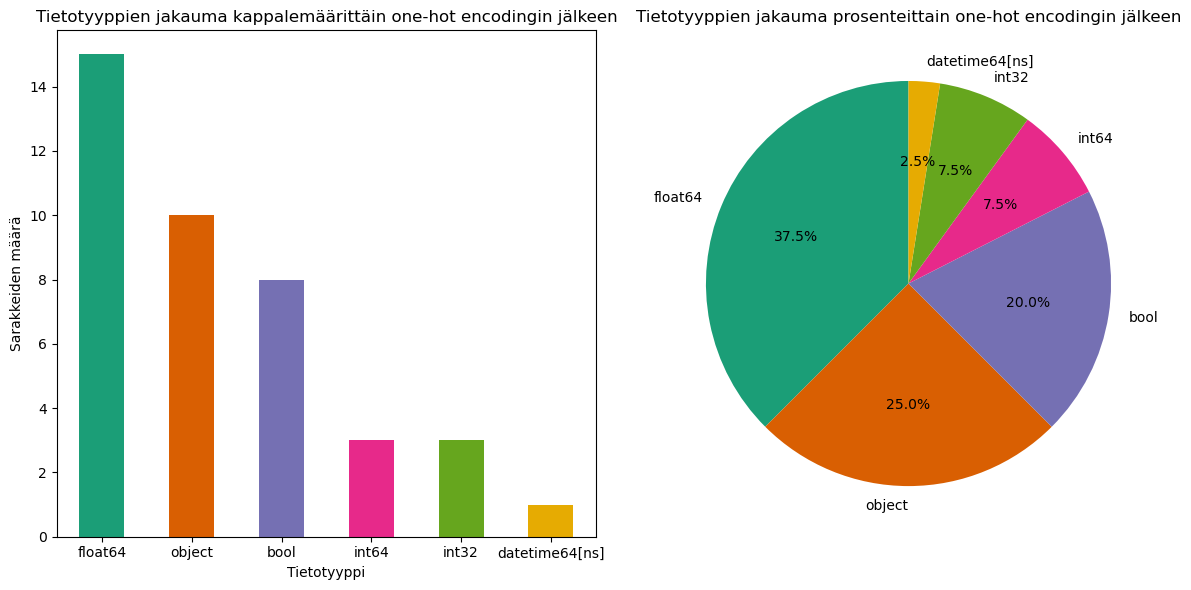

In [39]:
import matplotlib.pyplot as plt

data_types_plot3 = dataframe.dtypes.value_counts()

fig, axes = plt.subplots(1, 2, figsize=(12,6))

# Barplot
data_types_plot3.plot(
    kind="bar",
    ax=axes[0],
    title="Tietotyyppien jakauma kappalemäärittäin one-hot encodingin jälkeen",
    xlabel="Tietotyyppi",
    ylabel="Sarakkeiden määrä",
    color=colors
)

axes[0].tick_params(axis="x", rotation=0)

# Pie
data_types_plot3.plot(
    kind="pie",
    ax=axes[1],
    autopct="%1.1f%%",
    startangle=90,
    title="Tietotyyppien jakauma prosenteittain one-hot encodingin jälkeen",
    ylabel="",
    colors=colors
)

# Show the plot
plt.tight_layout()
plt.show()

In [40]:
import pandas as pd

# Define a function to identify outliers in each numerical column
def check_outliers(cleaned_df2, threshold=0.5):
    outlier_rows = {}
    
    # Loop through all numerical columns in the dataframe
    for col in cleaned_df2.select_dtypes(include=['number']).columns:
        # Calculate the 0.5% min and max thresholds
        min_threshold = cleaned_df2[col].quantile(threshold / 100)
        max_threshold = cleaned_df2[col].quantile(1 - threshold / 100)
        
        # Identify rows that are below the min threshold or above the max threshold
        min_outliers = cleaned_df2[cleaned_df2[col] <= min_threshold]
        max_outliers = cleaned_df2[cleaned_df2[col] >= max_threshold]
        
        # Store the counts and the rows for both min and max outliers
        outlier_rows[col] = {
            'min_count': len(min_outliers),
            'max_count': len(max_outliers),
            'min_outliers_head': min_outliers.head()[col],
            'max_outliers_head': max_outliers.head()[col]
        }
    
    return outlier_rows

# Apply the function to your DataFrame (use cleaned_df2 as an example)
outlier_info = check_outliers(cleaned_df2)

# Show only the column names and the head of the outliers
for col, info in outlier_info.items():
    print(f"Column: {col}")
    print(f"  - Bottom 0.5% Head:")
    print(info['min_outliers_head'])
    print(f"  - Top 0.5% Head:")
    print(info['max_outliers_head'])
    print('-' * 40)


Column: back_legroom
  - Bottom 0.5% Head:
40     27.3
71     27.1
393    27.1
408    28.2
410     0.0
Name: back_legroom, dtype: float64
  - Top 0.5% Head:
663     45.2
1148    45.2
1291    45.2
1305    45.2
1403    45.2
Name: back_legroom, dtype: float64
----------------------------------------
Column: daysonmarket
  - Bottom 0.5% Head:
644     0
745     0
1162    0
1307    0
1314    0
Name: daysonmarket, dtype: int64
  - Top 0.5% Head:
239     589
688     633
691     698
861     677
1343    570
Name: daysonmarket, dtype: int64
----------------------------------------
Column: dealer_zip
  - Bottom 0.5% Head:
0    960.0
1    922.0
4    922.0
5    922.0
6    960.0
Name: dealer_zip, dtype: float64
  - Top 0.5% Head:
16637    91401.0
16676    91401.0
16770    91401.0
16811    91401.0
16812    91401.0
Name: dealer_zip, dtype: float64
----------------------------------------
Column: engine_displacement
  - Bottom 0.5% Head:
605     1200.0
2766    1000.0
3162    1000.0
3347    1000.0
4176  

100%|██████████| 796451/796451 [00:11<00:00, 67239.24it/s]


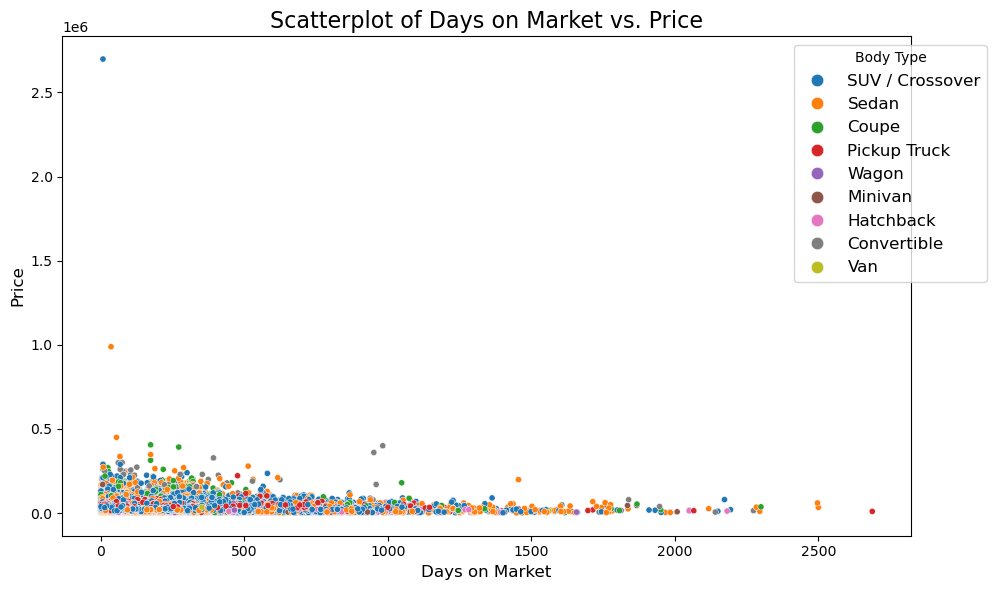

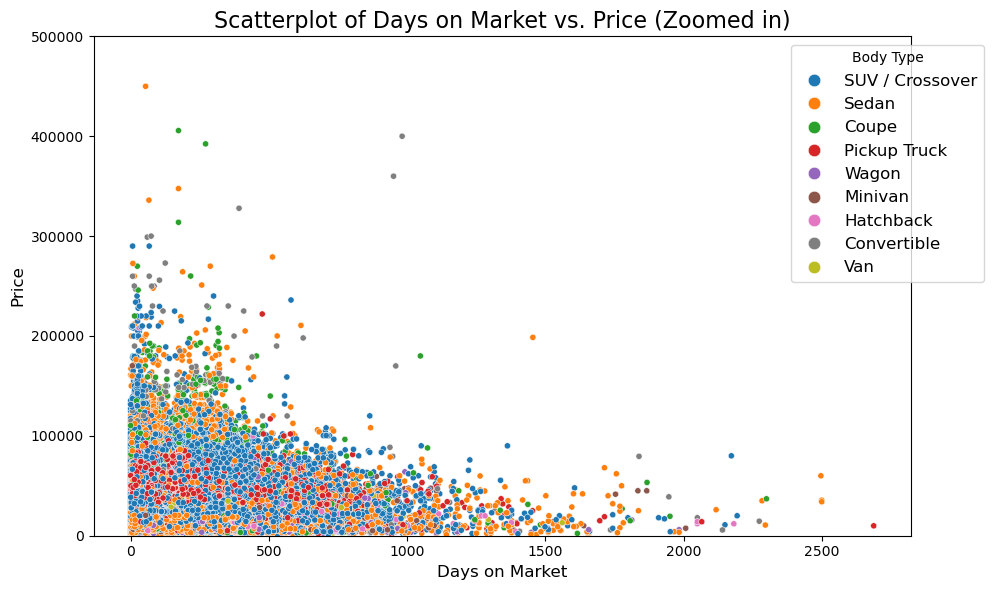

In [41]:
import seaborn as sns
# Ensure tqdm works with pandas apply
tqdm.pandas()

# Identify all columns starting with 'body_'
body_columns = [col for col in cleaned_df2.columns if col.startswith('body_')]

# Create a new column 'body_color' that will store the color for each point
def assign_color(row):
    # Check which 'body_' column has a True value and assign the column name as the color
    for col in body_columns:
        if row[col] == True:
            return col  # Use the column name as the color
    return 'gray'  # Default color for rows with no True values

# Apply the function to create the 'body_color' column with a progress bar
cleaned_df2['body_color'] = cleaned_df2.progress_apply(assign_color, axis=1)

# Create the first scatterplot (entire range)
plt.figure(figsize=(10, 6))
sns.scatterplot(x='daysonmarket', y='price', data=cleaned_df2, hue='body_color', palette='tab10', legend='full', s=20)  # Adjusted size with s=20

# Set the title and labels for the first plot
plt.title('Scatterplot of Days on Market vs. Price', fontsize=16)
plt.xlabel('Days on Market', fontsize=12)
plt.ylabel('Price', fontsize=12)

# Customize the legend
handles, labels = plt.gca().get_legend_handles_labels()
# Update the legend labels to show in the desired format
new_labels = [label.replace('body_type_', '') for label in labels]

# Increase the size of the legend markers
plt.legend(handles=handles, labels=new_labels, title='Body Type', loc='upper right', bbox_to_anchor=(1.1, 1), fontsize=12, markerscale=2)

# Show the first plot
plt.tight_layout()
plt.show()

# Create the second scatterplot (zoomed-in on price)
plt.figure(figsize=(10, 6))
sns.scatterplot(x='daysonmarket', y='price', data=cleaned_df2, hue='body_color', palette='tab10', legend='full', s=20)  # Adjusted size with s=20

# Set the title and labels for the second plot
plt.title('Scatterplot of Days on Market vs. Price (Zoomed in)', fontsize=16)
plt.xlabel('Days on Market', fontsize=12)
plt.ylabel('Price', fontsize=12)

# Zoom into the price axis (limit to 500,000)
plt.ylim(0, 500000)

# Customize the legend again
handles, labels = plt.gca().get_legend_handles_labels()
new_labels = [label.replace('body_type_', '') for label in labels]

# Increase the size of the legend markers
plt.legend(handles=handles, labels=new_labels, title='Body Type', loc='upper right', bbox_to_anchor=(1.1, 1), fontsize=12, markerscale=2)

# Show the second plot
plt.tight_layout()
plt.show()


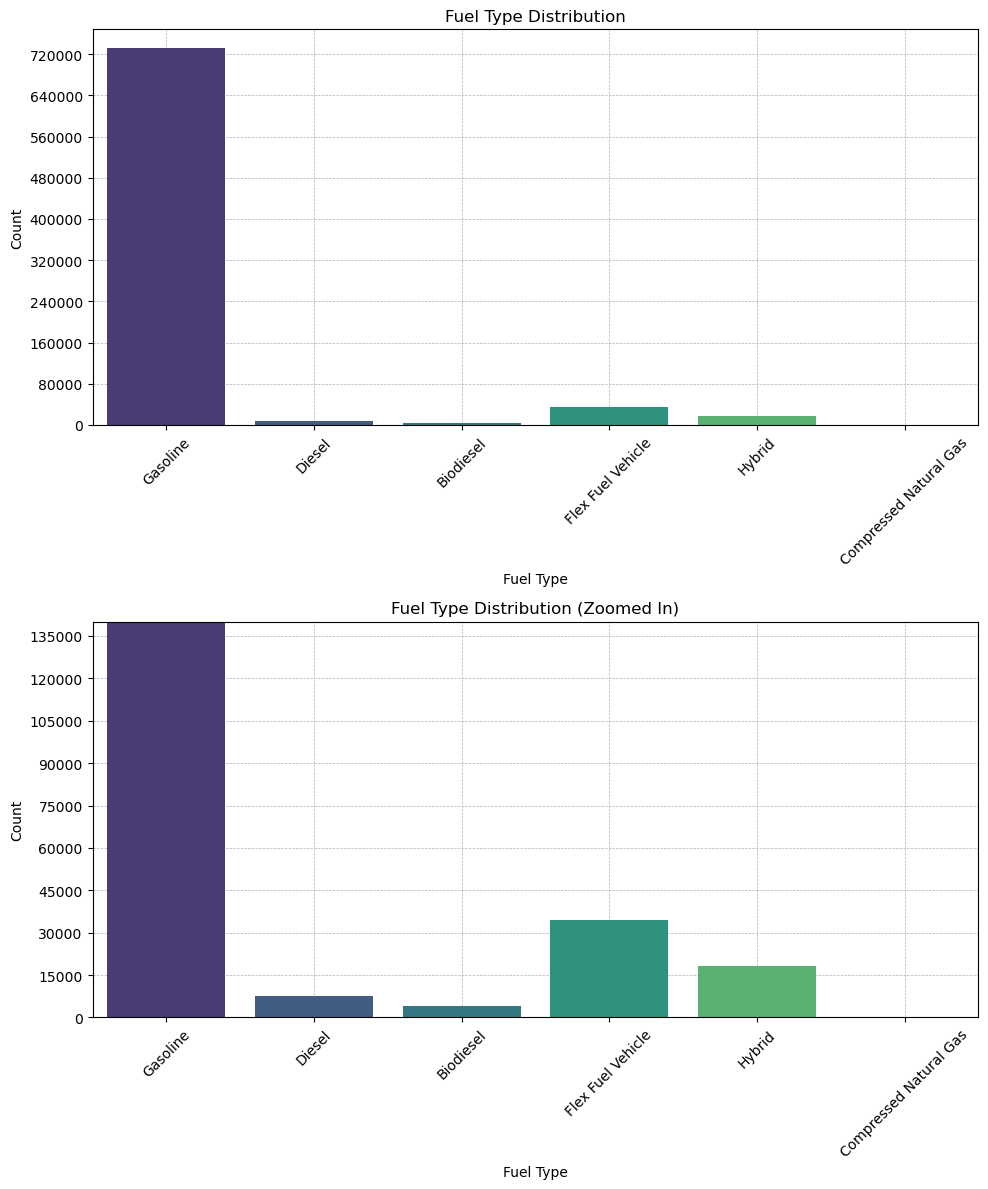

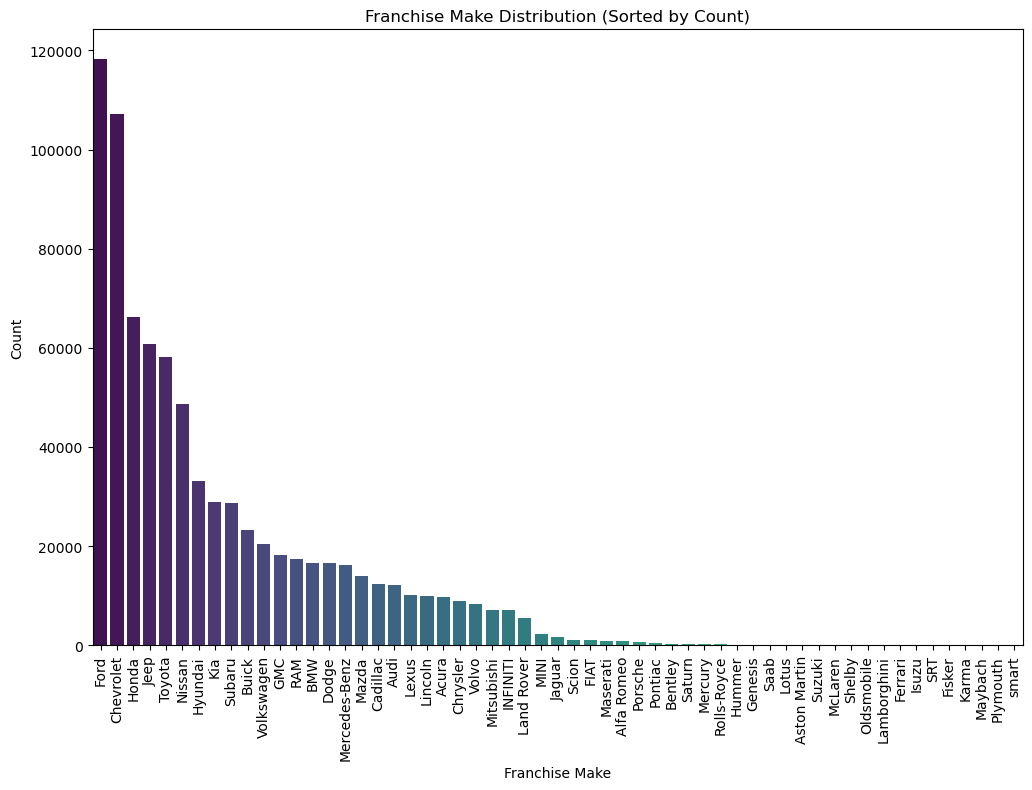

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator

# Create a 2x1 grid for the subplots
fig, axes = plt.subplots(2, 1, figsize=(10, 12))

# Plot the full distribution of fuel types
sns.countplot(x='fuel_type', data=cleaned_df2, palette='viridis', ax=axes[0], zorder=2)
axes[0].set_title('Fuel Type Distribution')
axes[0].set_xlabel('Fuel Type')
axes[0].set_ylabel('Count')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)
axes[0].yaxis.set_major_locator(MaxNLocator(integer=True))
axes[0].grid(True, which='both', linestyle='--', linewidth=0.5, zorder=1)

# Plot the zoomed-in distribution (up to 200,000)
sns.countplot(x='fuel_type', data=cleaned_df2, palette='viridis', ax=axes[1], zorder=2)
axes[1].set_title('Fuel Type Distribution (Zoomed In)')
axes[1].set_xlabel('Fuel Type')
axes[1].set_ylabel('Count')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)
# Set the y-axis limit for zoom
axes[1].set_ylim(0, 140000)
axes[1].yaxis.set_major_locator(MaxNLocator(integer=True))
axes[1].grid(True, which='both', linestyle='--', linewidth=0.5, zorder=1)


plt.tight_layout()
plt.show()

# Get sorted value counts for franchise_make
sorted_make_counts = cleaned_df2['franchise_make'].value_counts().sort_values(ascending=False)

# Plot sorted distribution of franchise makes
plt.figure(figsize=(12, 8))
sns.countplot(x='franchise_make', data=cleaned_df2, order=sorted_make_counts.index, palette='viridis')
plt.title('Franchise Make Distribution (Sorted by Count)')
plt.xlabel('Franchise Make')
plt.ylabel('Count')
plt.xticks(rotation=90)  # Rotate x-axis labels if necessary
plt.show()

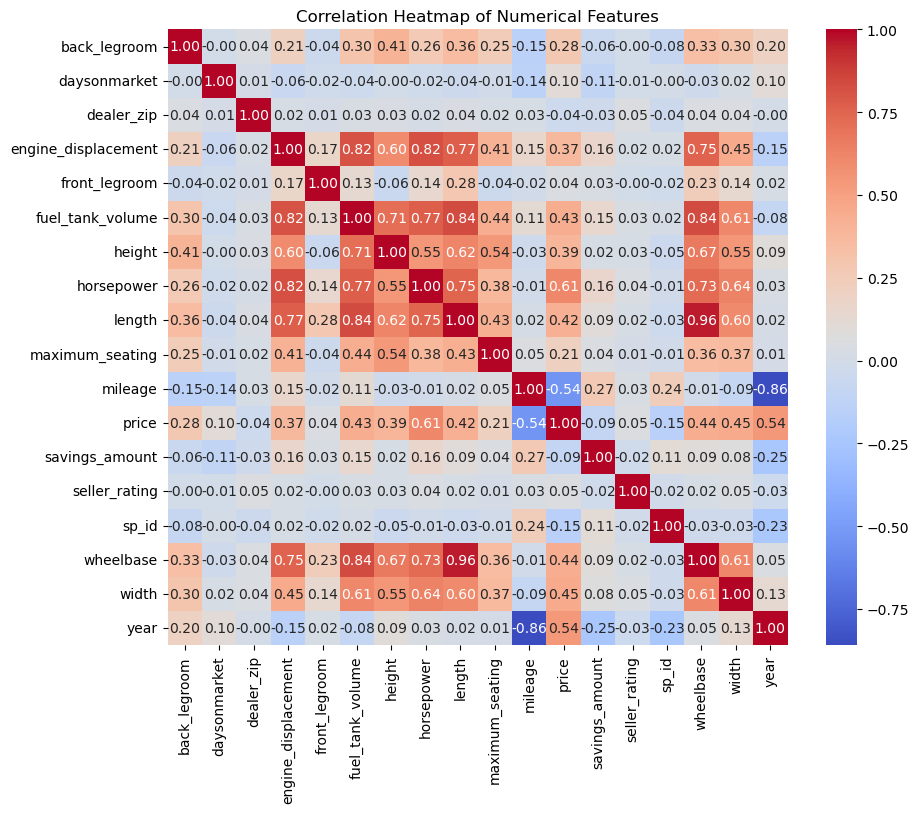

In [43]:
# Select numerical features for correlation heatmap
numerical_columns = cleaned_df2.select_dtypes(include=['float64', 'int64']).columns
corr_matrix = cleaned_df2[numerical_columns].corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', cbar=True)
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

In [44]:
from collections import defaultdict
boolean_columns = cleaned_df2.dtypes == 'bool'
bool_columns_list = cleaned_df2.columns[boolean_columns].tolist()

grouped_columns = defaultdict(list)
for col in bool_columns_list:
    prefix = col.split('_')[0]  # Extract prefix (substring before the first '_')
    grouped_columns[prefix].append(col)

# Convert defaultdict to a regular dictionary for easier reading
grouped_columns = dict(grouped_columns)

# Display the grouped columns
for group, items in grouped_columns.items():
    print(f"{group}: {items}")

fleet: ['fleet']
frame: ['frame_damaged']
franchise: ['franchise_dealer']
has: ['has_accidents']
isCab: ['isCab']
is: ['is_new']
salvage: ['salvage']
theft: ['theft_title']
wheel: ['wheel_4X2', 'wheel_All-Wheel Drive', 'wheel_Four-Wheel Drive', 'wheel_Front-Wheel Drive', 'wheel_Rear-Wheel Drive']
transmission: ['transmission_A', 'transmission_CVT', 'transmission_Dual Clutch', 'transmission_M']
body: ['body_type_Convertible', 'body_type_Coupe', 'body_type_Hatchback', 'body_type_Minivan', 'body_type_Pickup Truck', 'body_type_SUV / Crossover', 'body_type_Sedan', 'body_type_Van', 'body_type_Wagon']
listing: ['listing_color_black, unknown', 'listing_color_purple, pink, teal', 'listing_color_red, blue, green, brown', 'listing_color_white, gray, silver', 'listing_color_yellow, orange, gold']


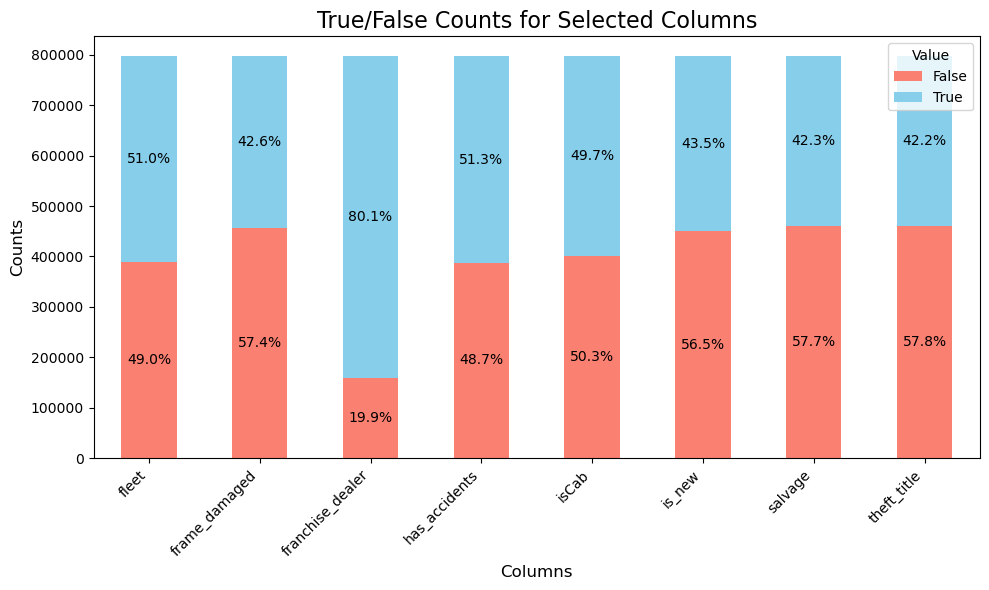

In [45]:
# Define the specific columns
columns = ['fleet', 'frame_damaged', 'franchise_dealer', 'has_accidents', 'isCab', 'is_new', 'salvage', 'theft_title']

# Count True and False values for each column
counts = cleaned_df2[columns].apply(pd.Series.value_counts).fillna(0).astype(int)

# Transpose the counts DataFrame for better plotting (columns become True/False, and indices are the specific column names)
counts = counts.T  # This makes the rows as columns and columns as values

# Plotting the stacked bar chart
ax = counts.plot(kind='bar', stacked=True, color=['salmon', 'skyblue'], figsize=(10, 6))

# Customize the plot
plt.title('True/False Counts for Selected Columns', fontsize=16)
plt.xlabel('Columns', fontsize=12)
plt.ylabel('Counts', fontsize=12)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
plt.legend(title='Value', labels=['False', 'True'])

# Display percentages on top of the bars
for i, p in enumerate(ax.patches):
    # Get the total count for each column (True + False)
    total = counts.iloc[i // 2].sum()  # Each column has two bars (True, False), so divide by 2 to get the correct row index
    height = p.get_height()
    
    # Calculate the percentage
    percentage = (height / total) * 100
    
    # Calculate the x-position for each bar and display the percentage text
    x_position = p.get_x() + p.get_width() / 2
    y_position = p.get_y() + height / 2  # Place text in the middle of the bar
    
    ax.text(
        x_position, y_position, f'{percentage:.1f}%', ha='center', va='center', fontsize=10, color='black'
    )

plt.tight_layout()  # Adjust layout to fit all elements
plt.show()


In [46]:
# Count the number of True and False values in the 'fleet' column
true_count_fleet = cleaned_df2['fleet'].value_counts().get(True, 0)
false_count_fleet = cleaned_df2['fleet'].value_counts().get(False, 0)

print(f"Number of True values in 'fleet': {true_count_fleet}")
print(f"Number of False values in 'fleet': {false_count_fleet}")

Number of True values in 'fleet': 406471
Number of False values in 'fleet': 389980


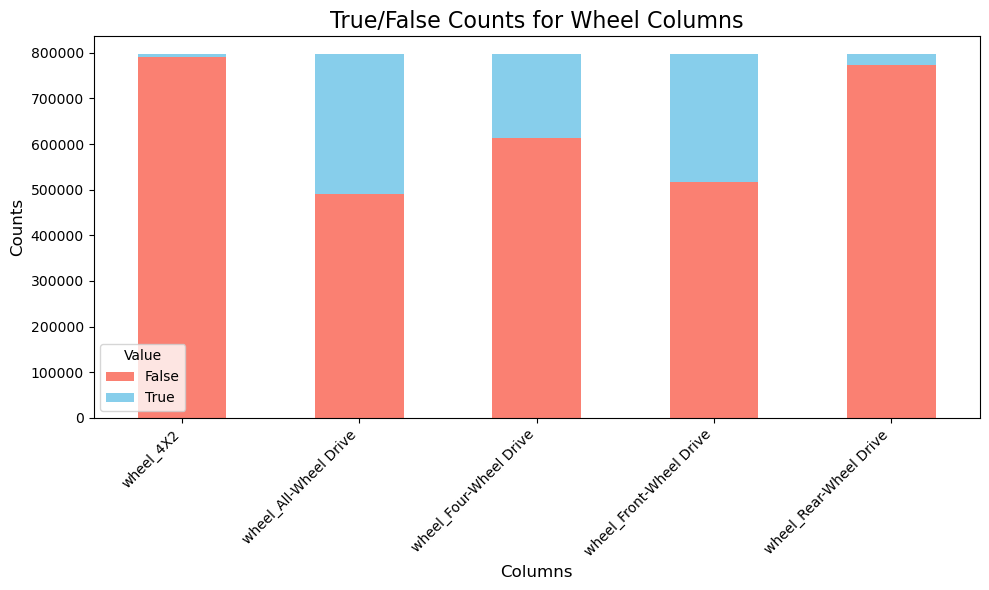

In [47]:
# Filter columns that start with 'wheel'
wheel_columns = [col for col in cleaned_df2.columns if col.startswith('wheel_')]

# Count True and False values for each column
counts = cleaned_df2[wheel_columns].apply(pd.Series.value_counts).fillna(0).astype(int)

# Transpose the counts DataFrame for better plotting
counts = counts.T  # Columns become 'True' and 'False', and indices are 'wheel_*'

# Plotting the stacked bar chart
counts.plot(kind='bar', stacked=True, color=['salmon', 'skyblue'], figsize=(10, 6))

# Customize the plot
plt.title('True/False Counts for Wheel Columns', fontsize=16)
plt.xlabel('Columns', fontsize=12)
plt.ylabel('Counts', fontsize=12)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
plt.legend(title='Value', labels=['False', 'True'])
plt.tight_layout()  # Adjust layout to fit all elements

# Show the plot
plt.show()

Processing group: Wheel Columns
True counts for Wheel Columns: wheel_All-Wheel Drive      305045
wheel_Four-Wheel Drive     183777
wheel_Front-Wheel Drive    278987
Other                       28642
dtype: int64


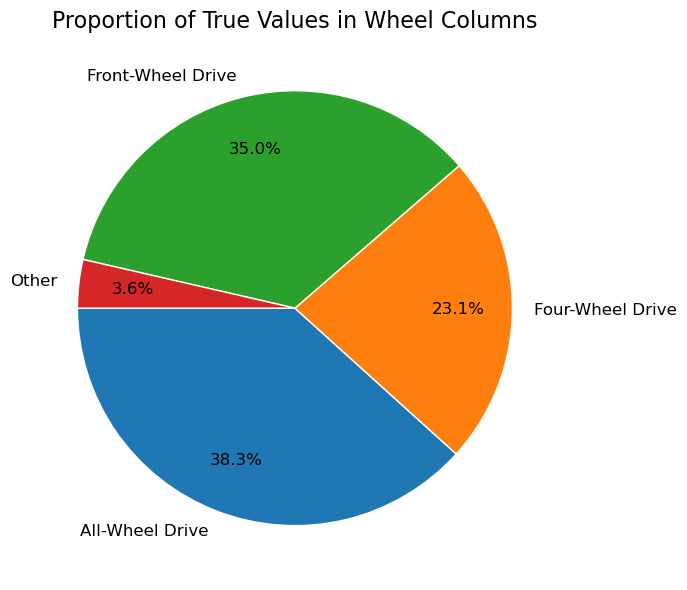

Completed group: Wheel Columns
Processing group: Transmission Columns
True counts for Transmission Columns: transmission_A      646977
transmission_CVT    133946
Other                15528
dtype: int64


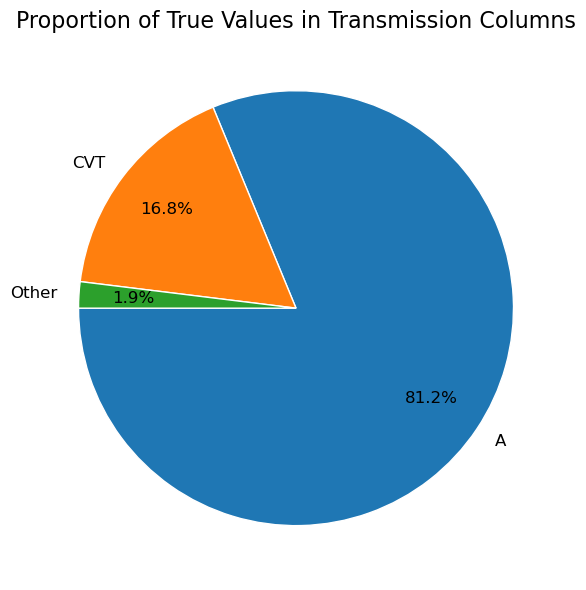

Completed group: Transmission Columns
Processing group: Body Type Columns
True counts for Body Type Columns: body_type_Pickup Truck        95411
body_type_SUV / Crossover    424629
body_type_Sedan              201613
Other                         74798
dtype: int64


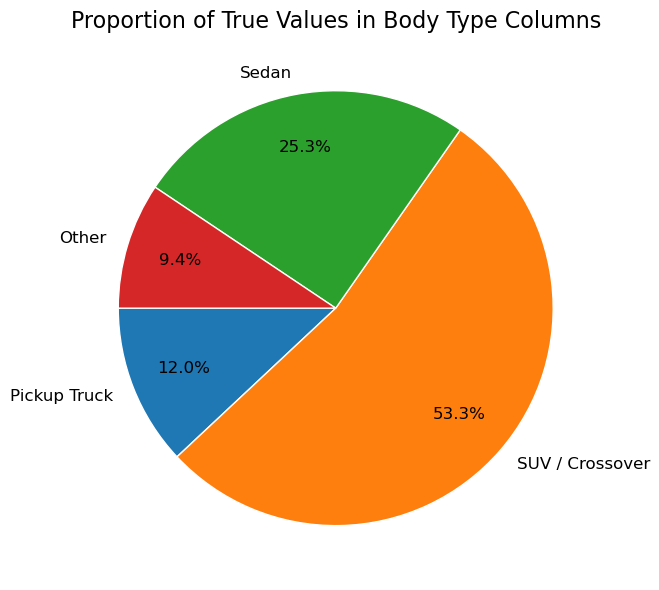

Completed group: Body Type Columns
Processing group: Listing Color Columns
True counts for Listing Color Columns: listing_color_black, unknown             275547
listing_color_red, blue, green, brown    156518
listing_color_white, gray, silver        355501
Other                                      8885
dtype: int64


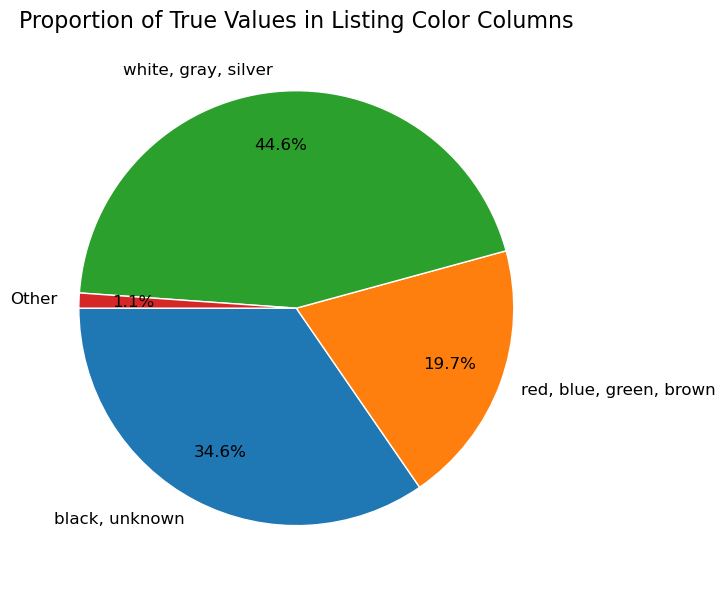

Completed group: Listing Color Columns
All groups processed.


In [54]:

# Function to process data and group small percentages into 'Other'
def process_data_for_pie(true_counts):
    total = true_counts.sum()
    percentages = (true_counts / total) * 100
    small_values = percentages < 3  # Threshold for small percentages
    if small_values.any():
        other_value = true_counts[small_values].sum()
        true_counts = true_counts[~small_values]
        true_counts['Other'] = other_value
    return true_counts

# Define prefixes for each group
groups = {
    'wheel_': 'Wheel Columns',
    'transmission_': 'Transmission Columns',
    'body_type_': 'Body Type Columns',
    'listing_color_': 'Listing Color Columns',
}

# Loop through each group and create pie charts
for prefix, title in groups.items():
    print(f"Processing group: {title}")
    
    # Filter columns that start with the prefix
    group_columns = [col for col in cleaned_df2.columns if col.startswith(prefix)]
    
    if not group_columns:
        print(f"No columns found for prefix: {prefix}")
        continue
    
    # Count the True values for each column
    true_counts = cleaned_df2[group_columns].sum()
    
    # Process data for pie chart (combine small percentages into "Other")
    true_counts = process_data_for_pie(true_counts)
    
    print(f"True counts for {title}: {true_counts}")
    
    plt.figure(figsize=(8, 6))
    plt.pie(
        true_counts, 
        labels=true_counts.index.str.replace(prefix, ''), 
        autopct='%1.1f%%', 
        startangle=180, 
        colors=plt.cm.tab10.colors[:len(true_counts)],
        textprops={'fontsize': 12},
        pctdistance=0.75,  # Adjust percentage text to be closer to the center
        wedgeprops={'linewidth': 1, 'edgecolor': 'white'},
    )
    plt.title(f'Proportion of True Values in {title}', fontsize=16)
    plt.tight_layout()
    plt.show()
    print(f"Completed group: {title}")

print("All groups processed.")


# Datan skaalaaminen ja malliin vietävät sarakkeet

In [50]:
from sklearn.preprocessing import LabelEncoder

fuel_type_encoder = LabelEncoder()
make_encoder = LabelEncoder()
city_encoder = LabelEncoder()
model_encoder = LabelEncoder()

#enkoodataan, niin monta saraketta
cleaned_df2['fuel_type_encoded'] = city_encoder.fit_transform(cleaned_df2['fuel_type'])
cleaned_df2['make_encoded'] = make_encoder.fit_transform(cleaned_df2['franchise_make'])
cleaned_df2['city_encoded'] = city_encoder.fit_transform(cleaned_df2['city'])
cleaned_df2['model_encoded'] = model_encoder.fit_transform(cleaned_df2['model_name'])

In [51]:
print(len(cleaned_df2['franchise_make'].unique()))
print(len(cleaned_df2['make_name'].unique()))
list1 = cleaned_df2['franchise_make'].unique()
list2 = cleaned_df2['make_name'].unique()

unique_to_list1 = set(list1) - set(list2)
print(unique_to_list1)

57
51
{'SRT', 'McLaren', 'Shelby', 'Lamborghini', 'Ferrari', 'smart', 'Lotus'}


Poistetaan siis vielä tuo make_name sillä sisältää vähemmän tietoja kuin franchise_make

In [52]:
# sarakkeet jota jätetään pois mallintamisen vaiheessa, tekstipohjaiset visuaalisaation jälkeen poistettava

pudotettavat = ['listing_color', 'make_name']
enkoodatut = ['fuel_type', 'franchise_make', 'city', 'model_name'] #jatkon kannalta talteen

cleaned_df2.drop(columns=pudotettavat, inplace=True)

final_df = cleaned_df2
final_df.head(2)

,back_legroom,city,daysonmarket,dealer_zip,engine_displacement,fleet,frame_damaged,franchise_dealer,franchise_make,front_legroom,fuel_tank_volume,fuel_type,has_accidents,height,horsepower,isCab,is_new,length,listed_date,major_options,maximum_seating,mileage,model_name,price,salvage,savings_amount,seller_rating,sp_id,theft_title,wheelbase,width,year,listed_year,listed_month,listed_dayofweek,wheel_4X2,wheel_All-Wheel Drive,wheel_Four-Wheel Drive,wheel_Front-Wheel Drive,wheel_Rear-Wheel Drive,transmission_A,transmission_CVT,transmission_Dual Clutch,transmission_M,body_type_Convertible,body_type_Coupe,body_type_Hatchback,body_type_Minivan,body_type_Pickup Truck,body_type_SUV / Crossover,body_type_Sedan,body_type_Van,body_type_Wagon,"listing_color_black, unknown","listing_color_purple, pink, teal","listing_color_red, blue, green, brown","listing_color_white, gray, silver","listing_color_yellow, orange, gold",body_color,fuel_type_encoded,make_encoded,city_encoded,model_encoded
0,35.1,Bayamon,522,960.0,1300.0,True,True,True,Jeep,41.2,12.7,Gasoline,True,66.5,177.0,True,True,166.6,2019-04-06,['Quick Order Package'],5.0,7.0,Renegade,23141.0,True,0,2.8,370599.0,True,101.2,79.6,2019,2019,4,5,False,False,False,True,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,body_type_SUV / Crossover,4,23,140,606
1,38.1,San Juan,207,922.0,2000.0,True,True,True,Land Rover,39.1,17.7,Gasoline,True,68.0,246.0,True,True,181.0,2020-02-15,['Adaptive Cruise Control'],7.0,8.0,Discovery Sport,46500.0,True,0,3.0,389227.0,True,107.9,85.6,2020,2020,2,5,False,True,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,body_type_SUV / Crossover,4,27,2350,209


### Datan skaalaaminen

In [53]:
#tähän skaalaukset



21.11.2024 klo 22.32: Mielestäni jää enää siis:

1. major_options <- sarakkeen käsittely (en ehtinyt yhtään paneutua tai miettiä mitenkä tämän kanssa) Oli kuitenkin yhtenä vaatimusmäärittelyn/asiakkaan kysymyksenä, miten lisäominaisuudet vaikuttavat haluttavuuteen

2. mahd. mietintä tehdäänkö "new features" eli tarviiko jotain lisätä? <- tätä joudetaa miettimään kun päästää eteenpäin
3. visualisaatio <- #Pekkatekeesunnuntaina ja saa muutkin tehdä ´:)
4. skaalaus
5. luokkamuuttujat?

## Phase 3 guide (Data Preparation)

* Select data
* Clean the data
* Integrate data
* Format data
* Construct the data

## Additional questions:

* Handling of missing values
* Handling of outliers
* Remove "unnecessary features"
* Add "new features"
* Also visualize after preprocessing
* Perform data scaling
* Classification class variable?

Important: The result data from this phase should have good quality for the next step, i.e. modeling.